<a href="https://colab.research.google.com/github/naim-sadeghian/thesis-project/blob/main/Tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias y datos

In [ ]:
#Clone github (libreria del profesor Omar)
!git clone https://github.com/omarcastano/JaverianaML.git

Cloning into 'JaverianaML'...
remote: Enumerating objects: 219, done.
remote: Total 219 (delta 0), reused 0 (delta 0), pack-reused 219
Receiving objects: 100% (219/219), 1.04 MiB | 10.66 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import tensorflow as tf
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestCentroid
from sklearn.metrics.pairwise import euclidean_distances
from JaverianaML import plots_util as pu
from JaverianaML import preprocessing_util
from sklearn.base import BaseEstimator, TransformerMixin
ds = pd.read_csv("ds2.csv")



#Escalamiento y pre-procesado

##Escalacion de datos

In [ ]:
#Escalacion de datos con metodo de pareto
class ParetoScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.factors = None

    def fit(self, X, y=None):
        self.factors = {col:X[col].std()**(1/2) for col in X}
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        for col in X_:
            X_[col] /= self.factors[col]
        return X_

NameError: ignored

In [ ]:
#Escalacion de datos
y = ds['y']
#print(ds)
datos = ds
datos = datos.drop('y',axis=1)
pareto = ParetoScaler()
datos = pareto.fit_transform(datos)

##Encontrar correlacionados

In [ ]:
#Correlacion de datos, observacion de los datos y observacion de los primeros 500 datos.
def get_redundant_pairs(datos):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = datos.columns
    for i in range(0, datos.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    l = len(au_corr)
    return au_corr[l-n:l]

print("Top Absolute Correlations")
print(get_top_abs_correlations(datos, 500))

In [ ]:
def sacarRelaciones(cor):
  #valores = [0 for _ in range(cor.shape[0])] ##Para poder contar relaciones por indice
  valores = [[] for _ in range(cor.shape[0])]
  for i in range(cor.shape[1]):
    valores[i].insert( 0, (1, i) ) #Se agrega a al mismo al inicio
    for j in range(i, cor.shape[1]):
      if i != j and cor.iloc[i,j] >= 0.875:
        #valores[i] += 1
        #valores[j] += 1
        valores[i].append( (cor.iloc[i,j], j) )
        valores[j].append( (cor.iloc[i,j], i) )
  return valores

from functools import cmp_to_key

def comp2(item1, item2):
  if len(item1) < len(item2):
    return 1

  elif len(item1) > len(item2):
    return -1

  elif len(item1) == 1 and len(item2) == 1:
    return 0

  else:
    prom1 = 0
    prom2 = 0
    for tupla in item1:
      prom1 += tupla[0]
    prom1 = prom1 / (len(item1)-1)

    for tupla in item2:
      prom2 += tupla[0]
    prom2 = prom2 / (len(item2)-1)

    if prom1 < prom2:
      return 1

    elif prom1 > prom2:
      return -1

    else:
      return 0


def listaDrop(grafo):
  visitado = [False for _ in range(len(grafo))] #Metabolitos visitados
  #drop = [False for _ in range(len(grafo))]
  drop = []
  for relacion in grafo:
    primero = relacion.pop(0) #Saca el primero, que es el metabolito al que se relacionan el resto
    if not(visitado[primero[1]]) and relacion != []:
      print("Dejo a: ", primero[1])
      print("----Quito a : ", end="")
      visitado[primero[1]] = True
      for peso, metabolito in relacion:
        if not(visitado[metabolito]):
          print("|", metabolito, end=" ")
          visitado[metabolito] = True
          #drop[metabolito] = True
          drop.append(metabolito)
      print()


  return drop






In [ ]:
df = pd.DataFrame(datos)
cor_matrix = df.corr().abs()
cor_matrix.shape[1]

grafo = sacarRelaciones(cor_matrix)
#print(grafo)
para_podar = listaDrop( sorted( grafo, key=cmp_to_key(comp2) ) ) #Lista de columnas para drop


Es de esperar que haya datos altamente correlacionados con un total aproximado de 14,000 correlaciones donde por la naturaleza de metabolitos hay metabolitos que son casi identicos a otros por lo que su nivel entre estos seria casi igual.

#Exploracion de Clusters

In [ ]:
data_km = datos.transpose()
datos_db = datos.transpose()
datos_gm = datos.transpose()
datos_h = datos.transpose()
datos_podados = datos.transpose()
#datos_podados.drop(index=datos_podados.index[para_podar], axis=0, inplace=True)
#print(datos_podados)

##Extraccion de cluster


In [ ]:
def most_frequent(List):
      counter = 0
      num = List[0]

      for i in List:
          curr_frequency = List.count(i)
          if(curr_frequency> counter):
              counter = curr_frequency
              num = i

      return num

def get_cluster(dataset, labels, cluster):
  aux = list(labels)
  if cluster == -1:
    cluster = most_frequent(aux)
  mapk = []
  i = 0
  for i in range(len(aux)):
    if aux[i] == cluster:
      mapk.append(str(i))
  return dataset.transpose()[mapk].copy()

##K-Vecinos

### Exploracion

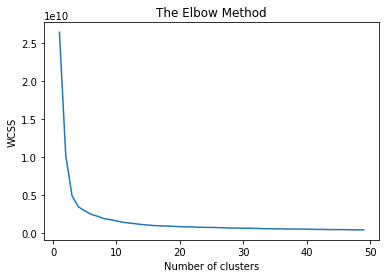

In [ ]:
wcss=[]
for i in range(1,50):
    kmeans=KMeans(n_clusters=i,
    init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(datos_h)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,50),wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

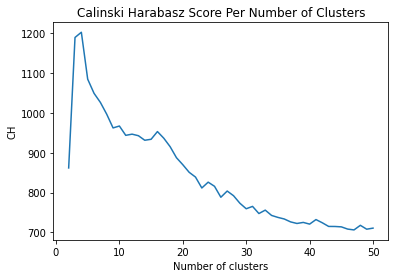

In [ ]:
wcss=[]
for n_clusters in range(2,51):
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(data_km)
    calinski_avg = calinski_harabasz_score(data_km, cluster_labels)
    wcss.append(calinski_avg)
plt.plot(range(2,51),wcss)
plt.title("Calinski Harabasz Score Per Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("CH")
plt.show()

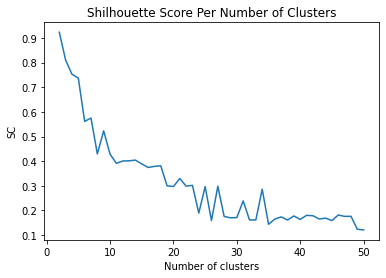

In [ ]:
wcss=[]
for n_clusters in range(2,51):
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(data_km)
    shilhouette_avg = silhouette_score(data_km, cluster_labels)
    wcss.append(shilhouette_avg)
plt.plot(range(2,51),wcss)
plt.title("Shilhouette Score Per Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("SC")
plt.show()

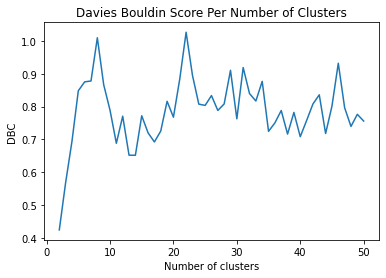

In [ ]:
wcss=[]
for n_clusters in range(2,51):
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(data_km)
    calinski_avg = davies_bouldin_score(data_km, cluster_labels)
    wcss.append(calinski_avg)
plt.plot(range(2,51),wcss)
plt.title("Davies Bouldin Score Per Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("DBC")
plt.show()

Vamos a agrupar grupos de metabolitos basados en los pacientes o vamos a agrupar pacientes basados en metabolitos?

In [ ]:
cluster_map_km[cluster_map_km.cluster == 0]

NameError: ignored

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import matplotlib.cm as cm
#score1 = davies_bouldin_score(datos_km.transpose(),cluster_labels)
#score2 = silhouette_score(datos_km.transpose(),cluster_labels)
#print(score1)
#score2

For n_clusters = 5 The average silhouette_score is : 0.7403449416450807
For n_clusters = 5 The average davies_bouldin_score is : 0.7718595044795175
For n_clusters = 5 The average calinski_harabasz_score is : 1084.4826726983695

For n_clusters = 10 The average silhouette_score is : 0.42806061502458054
For n_clusters = 10 The average davies_bouldin_score is : 0.7588328645130963
For n_clusters = 10 The average calinski_harabasz_score is : 926.2939556308213

For n_clusters = 15 The average silhouette_score is : 0.37882569563863827
For n_clusters = 15 The average davies_bouldin_score is : 0.6125808425903055
For n_clusters = 15 The average calinski_harabasz_score is : 948.4653069407972

For n_clusters = 20 The average silhouette_score is : 0.29832199442788
For n_clusters = 20 The average davies_bouldin_score is : 0.9149305341943036
For n_clusters = 20 The average calinski_harabasz_score is : 848.3589162062443

For n_clusters = 25 The average silhouette_score is : 0.21213824731096584
For n_cl

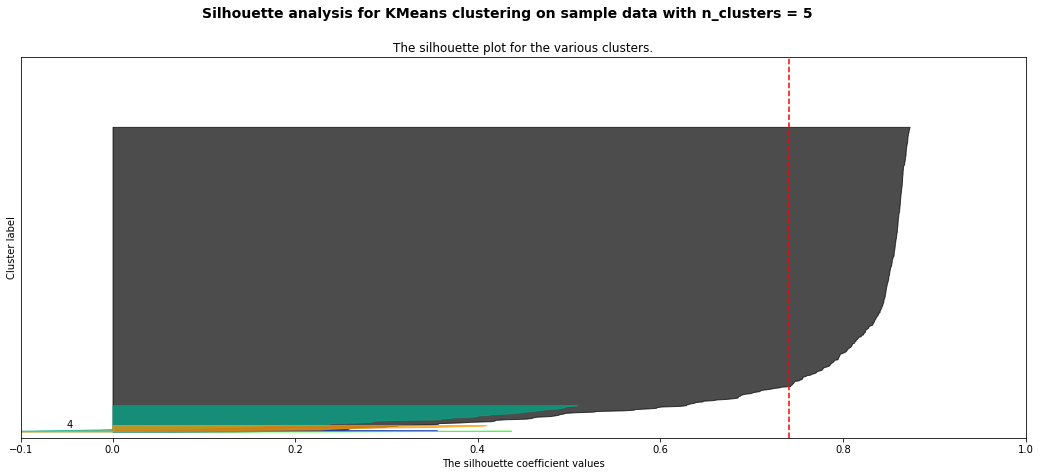

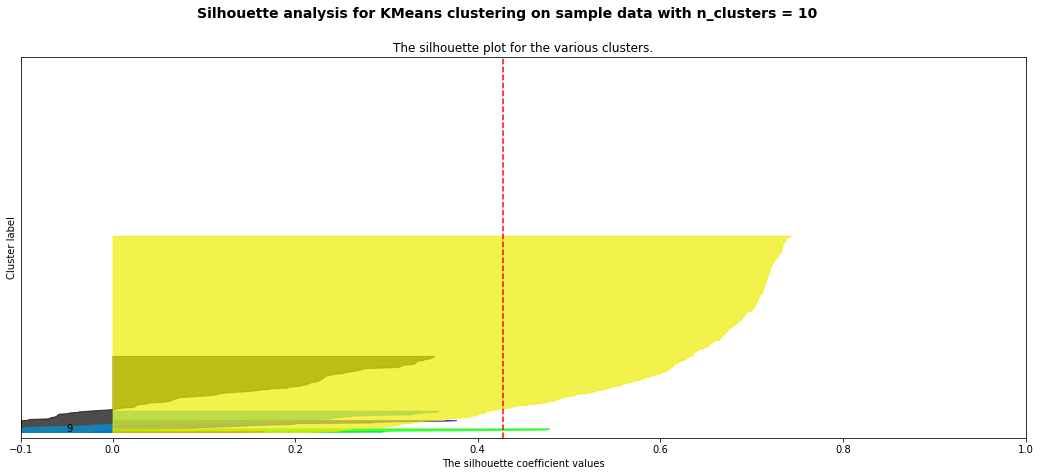

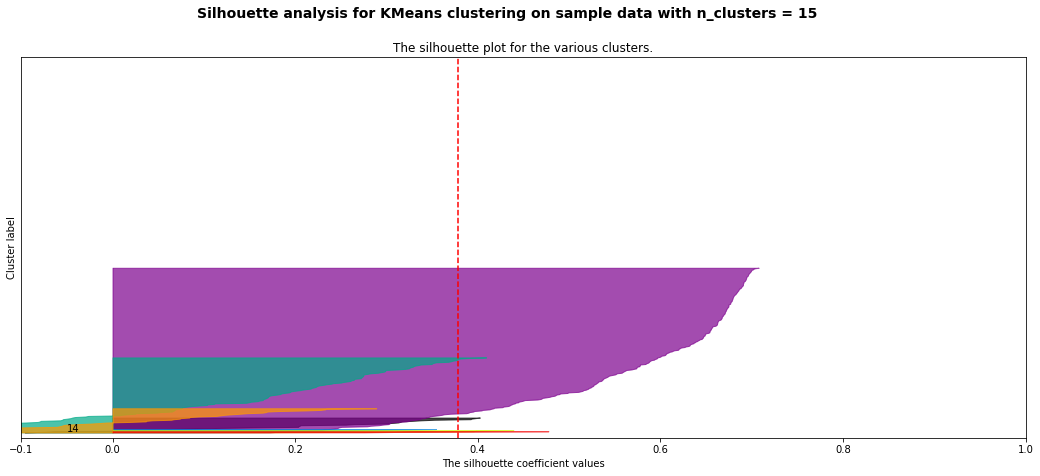

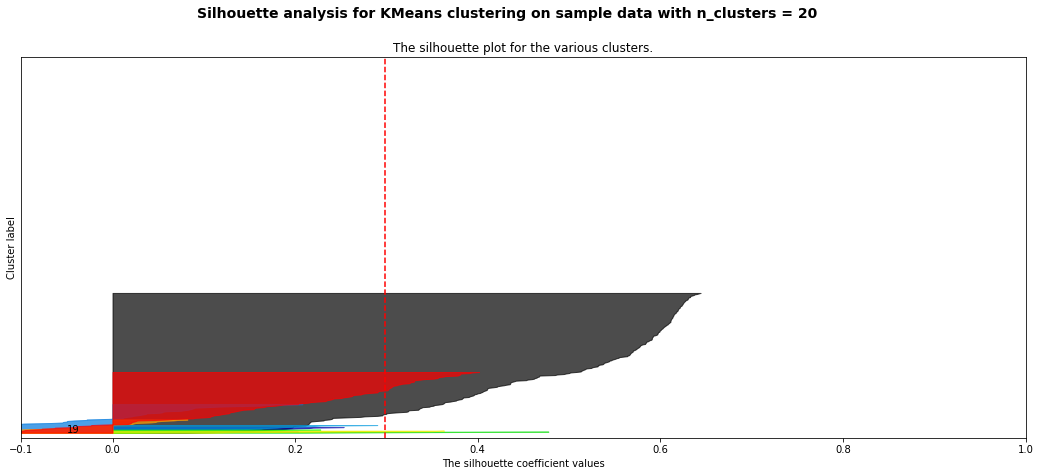

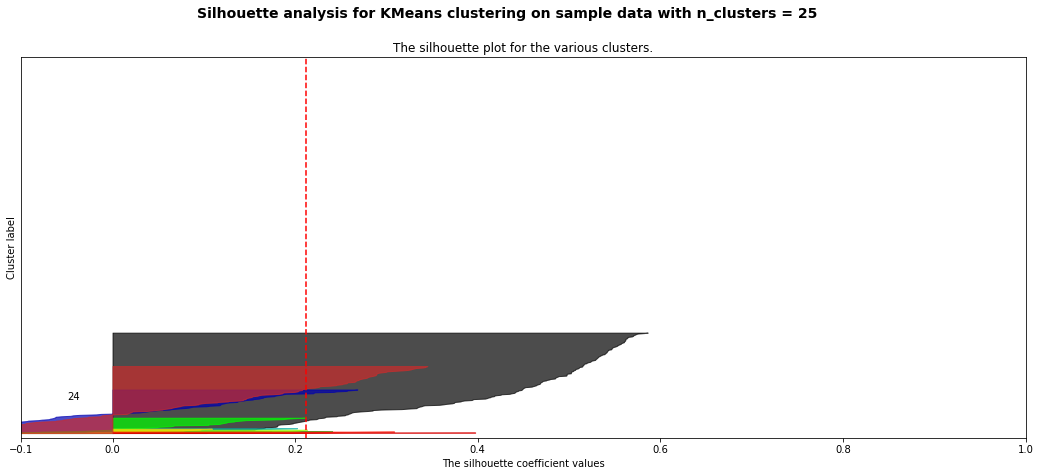

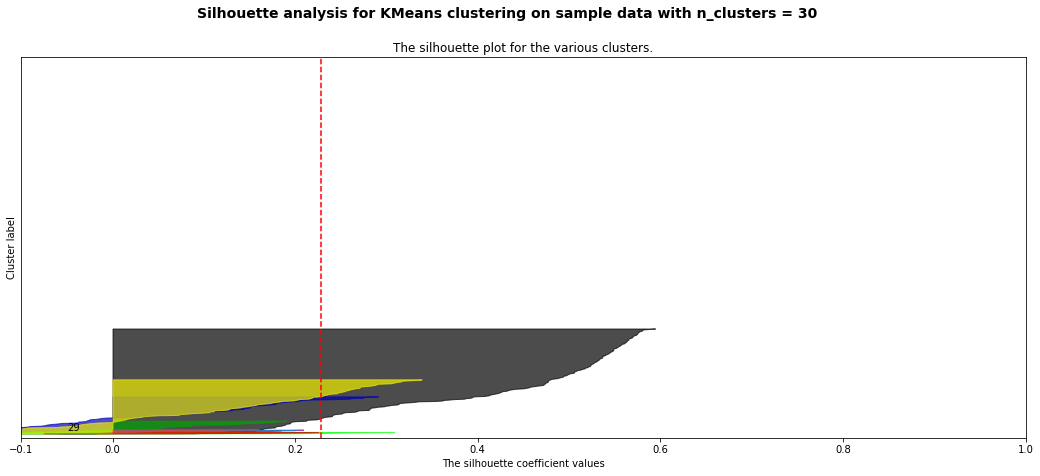

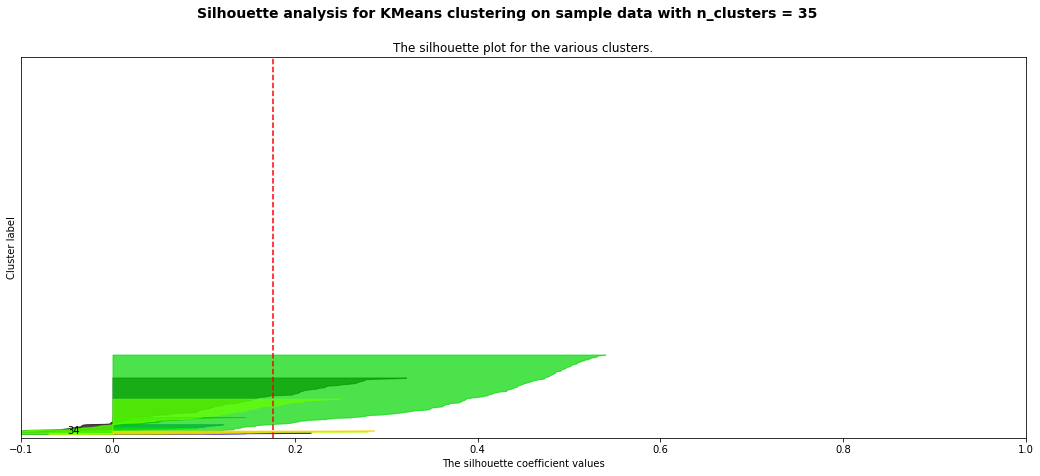

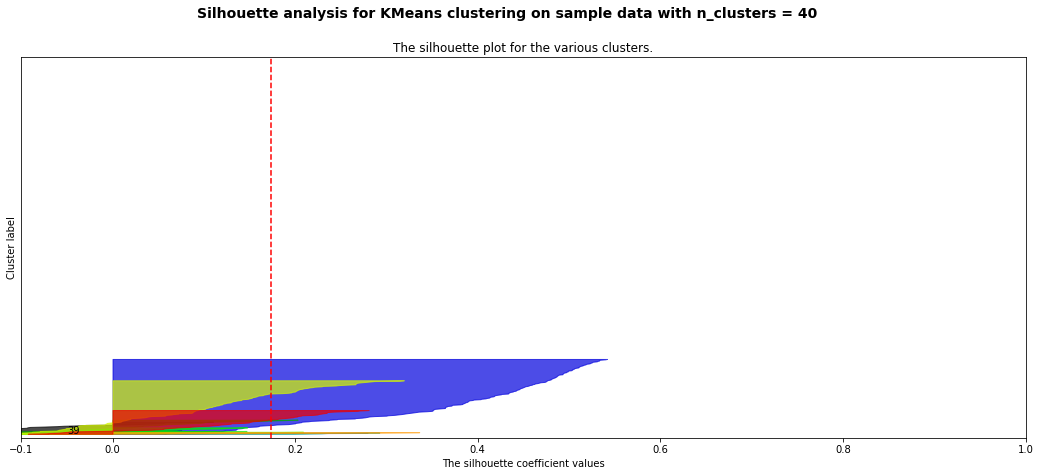

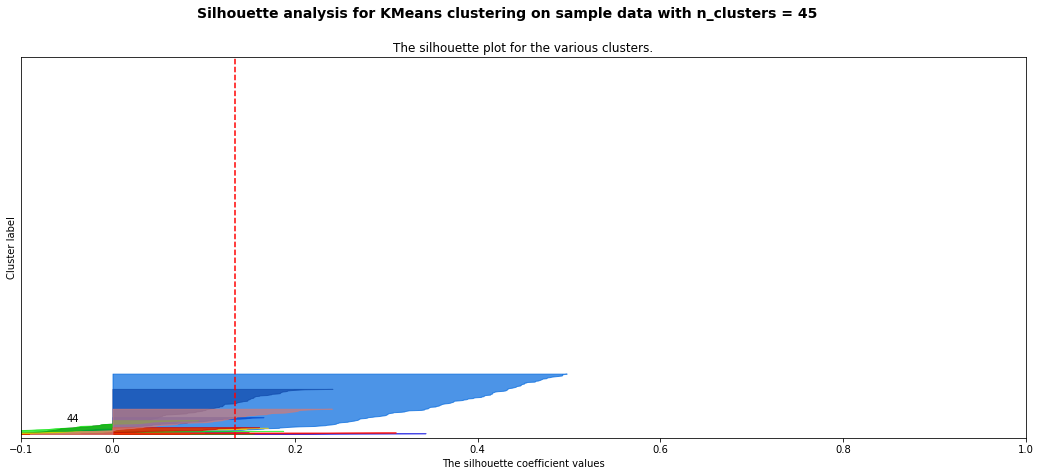

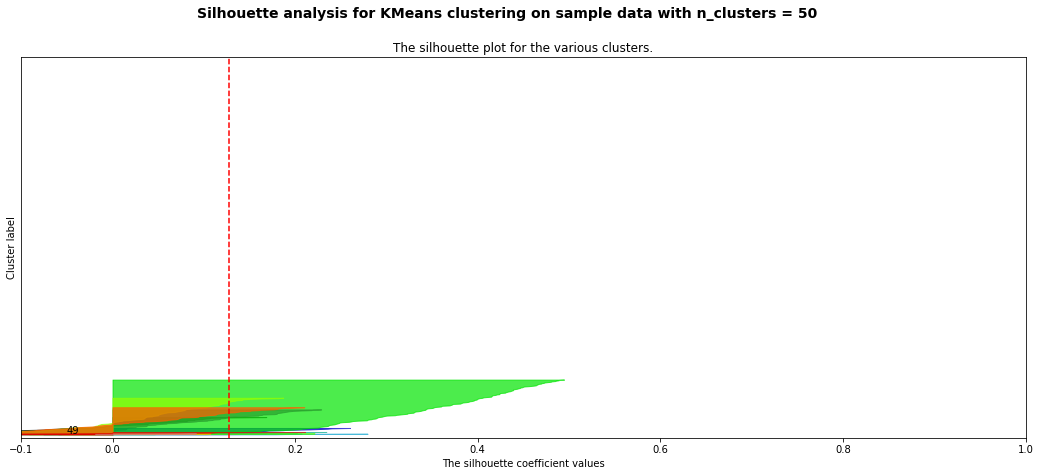

In [ ]:
range_n_clusters = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
for n_clusters in range_n_clusters:
  fig, (ax1) = plt.subplots(1)
  fig.set_size_inches(18, 7)
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(data_km) + (n_clusters + 1) * 10])
  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters)
  cluster_labels = clusterer.fit_predict(data_km)
  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(data_km, cluster_labels)
  bouldin_avg = davies_bouldin_score(data_km, cluster_labels)
  calinski_avg = calinski_harabasz_score(data_km, cluster_labels)
  print(
      "For n_clusters =",
      n_clusters,
      "The average silhouette_score is :",
      silhouette_avg,
  )
  print(
      "For n_clusters =",
      n_clusters,
      "The average davies_bouldin_score is :",
      bouldin_avg,
  )
  print(
      "For n_clusters =",
      n_clusters,
      "The average calinski_harabasz_score is :",
      calinski_avg,
  )
  print("")
  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(data_km, cluster_labels)
  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

  # Label the silhouette plots with their cluster numbers at the middle
  ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


  plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
  )

plt.show()

###Chosen cluster

In [ ]:
def tablaKMeans(x, data_km):
  def sacarTablaNClusters(x, datos):
    clusterer = KMeans(n_clusters=x)
    cluster_labels = clusterer.fit_predict(data_km)
    centros = clusterer.cluster_centers_
    #clusterer.labels_
    aux=datos.transpose()
    m = len(aux)
    n = len(aux.columns)
    mas_cercanos = []
    for c in range(x):
      i = 0
      val = -1
      minimo1 = math.inf
      while i < n:
        temp = aux[str(i)]
        euc = euclidean_distances([temp.to_numpy()], [centros[c]])
        if minimo1 > euc[0]:
          minimo1 = euc[0]
          val = i
        i += 1
      mas_cercanos.append(val)
      #print(minimo1)
    print(mas_cercanos)
    return list(map(lambda x: str(x), mas_cercanos))

  cols = sacarTablaNClusters(x, data_km)
  tablaKM = datos[cols].copy()
  return tablaKM

tablaKMeans(2, data_km)

[175, 77]


,175,77
0,551.562484,11356.782611
1,334.903424,7368.989366
2,311.536862,9095.142288
3,389.768645,10545.007110
4,281.756132,7363.740788
5,337.775300,7778.801909
6,375.167178,8154.989793
7,343.544121,8320.305458
8,335.056244,8078.671507
9,380.551126,7251.548971


In [ ]:

def sacarRepresentatesK(x, datos):
  clusterer = KMeans(n_clusters=x)
  cluster_labels = clusterer.fit_predict(datos)
  centros = clusterer.cluster_centers_
  #clusterer.labels_
  aux=datos.transpose()
  m = len(aux)
  n = len(aux.columns)
  mas_cercanos = []
  pos = []
  for i in range(5):
    for c in range(x):
      i = 0
      val = -1
      minimo1 = math.inf
      while i < n:
        temp = aux[str(i)]
        euc = euclidean_distances([temp.to_numpy()], [centros[c]])
        if (minimo1 > euc[0]) and (not( i in mas_cercanos)):
          minimo1 = euc[0]
          val = i
        i += 1

      mas_cercanos.append(val)
      pos.append(c)
  print(mas_cercanos)
  print(pos)


sacarRepresentatesK(5, data_km)


[94, 77, 527, 468, 252, 127, 352, 508, 85, 386, 331, 365, 392, 376, 229, 492, 80, 82, 137, 12, 453, 251, 391, 384, 316]
[0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]


In [ ]:
cols = list(map(lambda x: str(x), [352, 398, 452]))
tablaKM_Alt3 = datos[cols].copy()

cols = list(map(lambda x: str(x), [77, 127, 316, 392, 376])) #1 0 4 2
tablaKM_Alt5 = datos[cols].copy()

##DBSCAN




###Encontrar Epsilon con Nearest Neighbors

In [ ]:
from sklearn.neighbors import NearestNeighbors
def listar_vecinos(num_vecinos):
  #num_vecinos = 20 #Valor por ahora
  vecinos = NearestNeighbors(n_neighbors=num_vecinos)
  cercania_vecino = vecinos.fit(datos_db)
  distancias, indices = cercania_vecino.kneighbors(datos_db)
  return distancias

In [ ]:
#Encuentra el vecino mas lejano da cada individuo
def vecinoMasLejano(list_vecinos):
  lejanos = []
  for vecinos in list_vecinos:
    mas_lejano = max(vecinos)
    lejanos.append(mas_lejano)

  return lejanos

def encontrar_eps(cant):
  lejanos = vecinoMasLejano(listar_vecinos(cant))
  lejanos.sort()
  plt.plot(lejanos)
  return lejanos
  #plt.plot([0,536] , [7000,7000], 'r')
  #plt.plot([0,536] , [6000,6000], 'r')

#encontrar_eps(20)

In [ ]:
!pip install --upgrade kneed
from kneed import KneeLocator
def elbow(eps):
  y = encontrar_eps(eps)
  x = [i for i in range(536)]
  kn = KneeLocator(x, y, curve='convex', direction='increasing')
  codo = kn.elbow_y

  return codo


# for i in range(2,20):
#   print(elbow(i))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


15092.699231051778
Min samples =  2
Cluster:  2  | Metabolito:  77
Cluster:  2  | Metabolito:  352
[2, 532, 2, 0, 0]
3720.298069844392
Min samples =  3
Cluster:  2  | Metabolito:  379
Cluster:  2  | Metabolito:  393
Cluster:  2  | Metabolito:  398
[26, 507, 3, 0, 0]


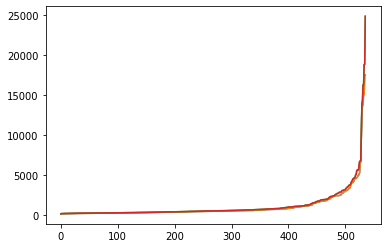

In [ ]:
for i in range(2, 4):
  print(elbow(i))
  cluster = [0,0,0,0,0]
  clustering = DBSCAN(eps=elbow(i), min_samples=i).fit(datos_db)
  print("Min samples = ", i)
  for c in range(len(clustering.labels_)):
    grupo = clustering.labels_[c]
    cluster[grupo+1] += 1
    if grupo in range(1,3):
      print("Cluster: ", grupo + 1, " | Metabolito: ", c)

  print(cluster)


  #encontrar_eps(i)


### Con los datos podados

### Pruebas con diferentes matricas de comparacion de parejas


### P = 1 y 3

In [ ]:
from sklearn.neighbors import NearestNeighbors
def listar_vecinos(num_vecinos):
  #num_vecinos = 20 #Valor por ahora
  vecinos = NearestNeighbors(n_neighbors=num_vecinos, p=3)
  cercania_vecino = vecinos.fit(datos_db)
  distancias, indices = cercania_vecino.kneighbors(datos_db)
  return distancias


#Encuentra el vecino mas lejano da cada individuo
def vecinoMasLejano(list_vecinos):
  lejanos = []
  for vecinos in list_vecinos:
    mas_lejano = max(vecinos)
    lejanos.append(mas_lejano)

  return lejanos

def encontrar_eps(cant):
  lejanos = vecinoMasLejano(listar_vecinos(cant))
  lejanos.sort()
  plt.plot(lejanos)
  return lejanos

!pip install --upgrade kneed
from kneed import KneeLocator
def elbow(eps):
  y = encontrar_eps(eps)
  x = [i for i in range(536)]
  kn = KneeLocator(x, y, curve='convex', direction='increasing')
  codo = kn.elbow_y

  return codo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


15092.699231051778
3720.298069844392
3260.9216890809857
4315.032532940725
4279.3698688575705
5932.35497179825
4565.474601661919
6911.357554688371
4434.28987055482
4585.283924023103
4818.929895056544
4859.054076253128
4849.45623850161
4875.435718136215
4963.870860543318
5675.553738118178
4985.385003260538
5007.377491960341


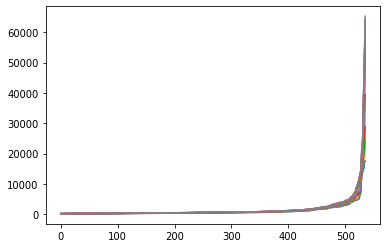

In [ ]:
for i in range(2, 20):
  print(elbow(i))

##Agglomerative (Hierarchy)

###Affinity -> *Euclidian*

####Linkage -> *Ward*

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
jer = AgglomerativeClustering(n_clusters=None,affinity = 'euclidean',linkage = 'ward', distance_threshold=0)
#labels = np.zeros((len(jer.children_),1))
Y = data_km
jer.fit(Y)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

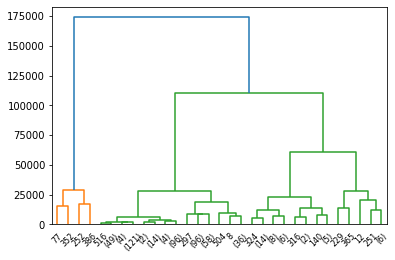

In [ ]:
den = sch.dendrogram(sch.linkage(Y, method = 'ward', metric = 'euclidean'), truncate_mode = 'level', p=5)

####Linkage -> *Average*

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
jer = AgglomerativeClustering(n_clusters=20,affinity = 'euclidean',linkage = 'average', compute_full_tree= True)
y_predict = jer.fit_predict(datos_h)
cluster_labels = jer.labels_
print(cluster_labels)
silhouette_avg = silhouette_score(datos_h, cluster_labels)
print(silhouette_avg)

[ 4  4  4  4  4  4  4  4  4  4  4  4 13  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  6  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4 15  4  0  5  4  0  4  4  5  4  4  4  2  0  4  4  4  4  0
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  0  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4 17  4  4 12  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  0  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  2  4  4  4  4  4  4  4  4  4 18  4  0  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4 19 11  4  4  4  4  0  4  4  4  4  4  4
  4  4  4  4  4  4  0  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  0  4  4 16  4  4  4  4  4  4  4  4  4  4  3  4  4  4
  4  4  0  4  8  4  4  4  4  4  4  4  0  4  4  4  4

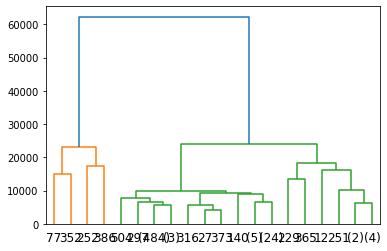

In [ ]:
den = sch.dendrogram(sch.linkage(Y, method = 'average', metric = 'euclidean'), truncate_mode = 'level', p=5)

####Linkage -> *Complete*

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
jer = AgglomerativeClustering(n_clusters=20,affinity = 'euclidean',linkage = 'complete')
#labels = np.zeros((len(jer.children_),1))
y_predict = jer.fit_predict(datos_h)
cluster_labels = jer.labels_
print(cluster_labels)
silhouette_avg = silhouette_score(datos_h, cluster_labels)
print(silhouette_avg)

[ 1  1  1  1  1  3  1  1  1  1  1  1 11  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  0  1  1  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  3  1  1  1  1  1
  1  1  1  1  1 17  1  2  6  1  2  1  1  6  1  1  1  4  2  3  1  1  1  8
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 19  1  1 16  1  1  1
  1  1  1  1  1  3  1  1  1  1  1  8  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  8  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  3  1  1  1  1  1  1  1  1  1  1
  1  1  1  4  3  1  1  1  1  1  1  1  1  9  1  3  1  1  1  1  1  1  1  1
  1  1  1  1  8  1  1  1  1  1  1 12 13  1  1  1  1  2  1  1  1  1  1  1
  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  3  3  1  1  1  1
  1  1  1  1  1  1  2  1  1 15  1  1  1  1  1  1  1  1  1  1  8  1  1  1
  1  1  3  3  0  1  1  1  1  1  1  1  3  1  1  1  1

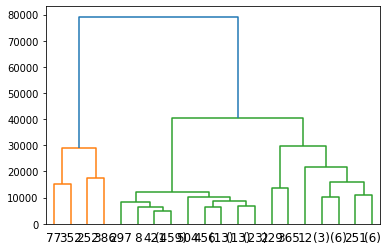

In [ ]:
den = sch.dendrogram(sch.linkage(Y, method = 'complete', metric = 'euclidean'), truncate_mode = 'level', p=5)

####Linkage -> *Single*

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
jer = AgglomerativeClustering(n_clusters=20,affinity = 'euclidean',linkage = 'single')
#labels = np.zeros((len(jer.children_),1))
y_predict = jer.fit_predict(datos_h)
cluster_labels = jer.labels_
print(cluster_labels)
silhouette_avg = silhouette_score(datos_h, cluster_labels)
print(silhouette_avg)

[ 0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 19  0  0  1  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0 10  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 17  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  8 16  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0

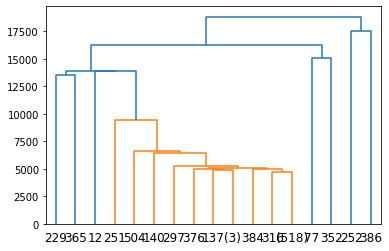

In [ ]:
den = sch.dendrogram(sch.linkage(Y, method = 'single', metric = 'euclidean'), truncate_mode = 'level', p=10)

###Affinity -> *manhatan*

####Linkage -> *Ward*

NA

####Linkage -> *Average*

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
jer = AgglomerativeClustering(n_clusters=20,affinity = 'manhattan',linkage = 'average', )
#labels = np.zeros((len(jer.children_),1))
y_predict = jer.fit_predict(datos_h)
cluster_labels = jer.labels_
print(cluster_labels)
silhouette_avg = silhouette_score(datos_h, cluster_labels)
print(silhouette_avg)

[ 6  6  6  6  6  6  6  6  6  6  6  6 13  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  1  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6 17  6  2  0  6  2  6  6  0  6  6  6  5  2  6  6  6  6  2
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  2  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6 15  6  6 14  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  2  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  2  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6 19  6  6  6  6  6  6  6  6  6 16  6  2  6  6  6  6  6  6  6  6
  6  6  6  6  2  6  6  6  6  6  6 10 11  6  6  6  6  2  6  6  6  6  6  6
  6  6  6  6  6  6  2  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  2  6  6  6  6  6  6  6  6  6  6  6  6  6  2  6  6  6
  6  6  2  6  7  6  6  6  6  6  6  6  2  6  6  6  6

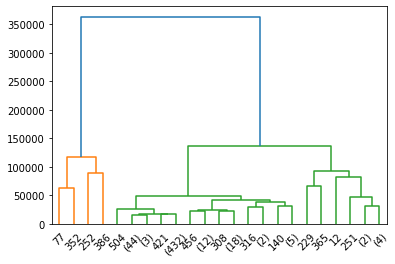

In [ ]:
den = sch.dendrogram(sch.linkage(Y, method = 'average', metric = 'cityblock'), truncate_mode = 'level', p=5)

####Linkage -> *Complete*

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
jer = AgglomerativeClustering(n_clusters=20,affinity = 'manhattan',linkage = 'complete')
#labels = np.zeros((len(jer.children_),1))
y_predict = jer.fit_predict(datos_h)
cluster_labels = jer.labels_
print(cluster_labels)
silhouette_avg = silhouette_score(datos_h, cluster_labels)
print(silhouette_avg)

[14 14 14 14 14  1 14 14  1  1 14 14 11  1 14  1 14  1 14 14 14 14 14 14
 14 14  1  8 14 14  1 14 14 14  1 14 14 14 14  1  1 14 14 14 14 14  1  1
  1 14  1 14  1 14 14 14 14 14 14 14 14 14 14  1 14 14  1 14  1 14 14  1
 14  1 14 14 14 10  1  3  2  1  3  1  1  2 14  1 14  0  3  1  1 14 14  7
  1 14 14 14  1 14 14  1  1  1 14  1 14 14 14 14  3  1 14  1  1  1 14 14
 14 14 14  1  1 14  1 14 14 14 14 14  1 14  1  1 14 19 14 14 16 14 14 14
 14  1  1  1 14  1  1 14 14  1  1  7  1  1  1 14  1 14 14 14 14 14 14 14
 14  1 14 14 14 14 14  1 14  1 14 14  1 14 14  1  1  7 14 14 14 14  1 14
 14 14  1 14  1 14 14 14 14 14 14 14 14  1 14 14 14 14 14  1 14 14 14 14
 14 14 14  0  1  1 14 14 14 14 14  1 14  9 14  7  1 14  1 14 14 14  1 14
 14 14 14  1  7 14 14 14 14 14 14 12 13 14  1 14 14  3 14  1  1 14 14 14
 14  1 14  1 14  1  3  1  1 14  1 14 14 14 14 14  1 14  1  1 14 14 14 14
 14 14 14  1 14 14  3 14  1 14  1 14 14  1 14 14 14 14 14 14  1 14 14  1
 14 14  7  1 17  1  1 14 14 14  1 14  7 14  1  1 14

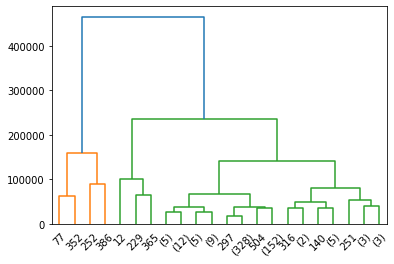

In [ ]:
den = sch.dendrogram(sch.linkage(Y, method = 'complete', metric = 'cityblock'), truncate_mode = 'level', p=5)

####Linkage -> *Single*

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
jer = AgglomerativeClustering(n_clusters=20,affinity = 'manhattan',linkage = 'single')
#labels = np.zeros((len(jer.children_),1))
y_predict = jer.fit_predict(datos_h)
cluster_labels = jer.labels_
print(cluster_labels)
silhouette_avg = silhouette_score(datos_h, cluster_labels)
print(silhouette_avg)

[ 0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 15  0  0 14  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0 10  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 18  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  7  9  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0

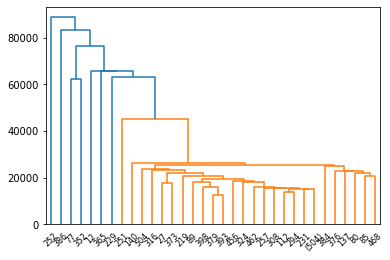

In [ ]:
den = sch.dendrogram(sch.linkage(Y, method = 'single', metric = 'cityblock'), truncate_mode = 'level', p=20)

###Affinity -> *cosine*

####Linkage -> *Ward*

NA

####Linkage -> *Average*

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
jer = AgglomerativeClustering(n_clusters=20,affinity = 'cosine',linkage = 'average')
#labels = np.zeros((len(jer.children_),1))
y_predict = jer.fit_predict(datos_h)
cluster_labels = jer.labels_
print(cluster_labels)
silhouette_avg = silhouette_score(datos_h, cluster_labels)
print(silhouette_avg)

[ 0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  6  0  0  0  0  0  1  0  0 15  0  0  3  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  8  0  0  0  0  0  0  2  0  0  0  0  0  0 12  0  0  0  0  0  5  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 17  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
  0  2  8  0  0  0  0  0 11 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 16  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

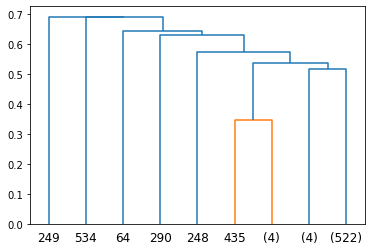

In [ ]:
den = sch.dendrogram(sch.linkage(Y, method = 'average', metric = 'cosine'), truncate_mode = 'level', p=6)

####Linkage -> *Complete*

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
jer = AgglomerativeClustering(n_clusters=20,affinity = 'cosine',linkage = 'complete')
#labels = np.zeros((len(jer.children_),1))
y_predict = jer.fit_predict(datos_h)
cluster_labels = jer.labels_
print(cluster_labels)
silhouette_avg = silhouette_score(datos_h, cluster_labels)
print(silhouette_avg)

[ 1  5  1  0  0  0  0  1 14  0  0  0  0  0  1  0  0  2  0  1  1  0  1  0
  1  1  1  0  2  2  0  1  0  2  0  1  0  1  0  0  0  0  1  3  0  1  1  1
  1  0  1  1  1  1  1 11  1  0  1  1  2  0  0  1  3  0  1 14  1  1  1  1
  1  2  2  2  1  1  0  2  1  2  0  1  1  1  1  1  1  1  1  0  1  0  1  0
  1  0  0  1  1  1  2  1  2  1  1  1  0  1  1  8  0  0  0  0  0  1  0  1
  1  1 18  1  1  1  1  1  0  4  0  0  1  1  1  1  6  1  1  1  0  1  7  1
  1  1  2  1  2  1  1  0  1  2  1  1  1  0  1  1  1  1  1  0  3  0  1  2
  1  1  1  0  8  1  1  1  0  1 15  1  2  0  2  0  1  1  1  1 15  1  1  1
  1  2  0  1  1  2  1  2  1  6  1  0  1  1  0  2  2  0  8  8  0  2  0  1
  1  2 19  1  1  1  2  2  0  0  2  0  8  1  7  2  1  2  0  2  1  0  0  0
  0  4 18  1  1  8  0  2  9 10  1  1  1  1  0  1  0  0  0  1  1  2  1  1
  1  1  1  1  1  1  1  1  1  2  1  2  1  2  0  1  2  2  1  2  8  0  1  1
  1  2 16  1  0  1  0  1  0  7  1  0  0  0  1  1  1  0  0  0  0  2  0  0
  1  2  0  0  1  0  0  1  2  0  1  0  1  0  1  1  1

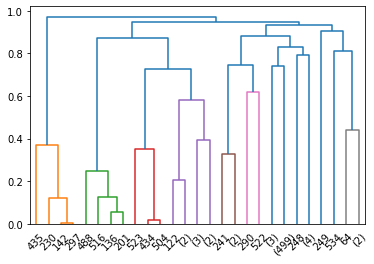

In [ ]:
den = sch.dendrogram(sch.linkage(Y, method = 'complete', metric = 'cosine'), truncate_mode = 'level', p=5)

####Linkage -> *Single*

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
jer = AgglomerativeClustering(n_clusters=20,affinity = 'cosine',linkage = 'single')
y_predict = jer.fit_predict(datos_h)
cluster_labels = jer.labels_
print(cluster_labels)
silhouette_avg = silhouette_score(datos_h, cluster_labels)
print(silhouette_avg)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2  0  0  0  0  0  9 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0
  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

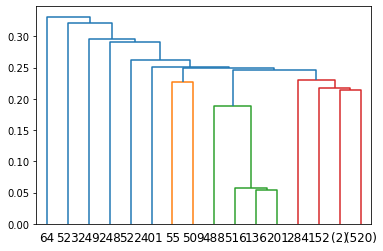

In [ ]:
den = sch.dendrogram(sch.linkage(Y, method = 'single', metric = 'cosine'), truncate_mode = 'level', p=10)

###Grilla Jerarquico


In [ ]:
n = 2
while n < 50:
  affinity = ['euclidean', 'manhattan','cosine','l1','l2' ]
  linkage = ['average', 'complete', 'single', 'ward']
  print("Para Cluster numero",n)
  max_link = ''
  max_aff = ''
  max_score = -1
  for link in linkage:
    if link == 'ward':
      temp = 'euclidean'
      jer = AgglomerativeClustering(n_clusters=n,affinity = temp,linkage = link, compute_full_tree= True)
      cluster_labels = jer.fit_predict(datos_h)
      silhouette_avg = silhouette_score(datos_h, cluster_labels)
      if silhouette_avg > max_score:
        max_link = link
        max_aff = temp
        max_score = silhouette_avg

    else:
      for elem in affinity:
        jer = AgglomerativeClustering(n_clusters=n,affinity = elem,linkage = link, compute_full_tree= True)
        cluster_labels = jer.fit_predict(datos_h)
        silhouette_avg = silhouette_score(datos_h, cluster_labels)
        if silhouette_avg > max_score:
          max_link = link
          max_aff = elem
          max_score = silhouette_avg
  print(max_aff,max_link,max_score)
  n += 1

Para Cluster numero 2
euclidean single 0.9369191909466671
Para Cluster numero 3
euclidean single 0.9285805879970199
Para Cluster numero 4
euclidean single 0.9196569845429825
Para Cluster numero 5
euclidean single 0.914088552033675
Para Cluster numero 6
euclidean single 0.8826348403682871
Para Cluster numero 7
euclidean single 0.86778809716228
Para Cluster numero 8
euclidean single 0.8662221000548753
Para Cluster numero 9
euclidean average 0.8292241605980522
Para Cluster numero 10
euclidean average 0.823341170043717
Para Cluster numero 11
manhattan single 0.7806814640036093
Para Cluster numero 12
manhattan single 0.7761432026327373
Para Cluster numero 13
euclidean average 0.7400187343647381
Para Cluster numero 14
euclidean average 0.7177771326332163
Para Cluster numero 15
manhattan average 0.7090881449867205
Para Cluster numero 16
manhattan average 0.7087006385340703
Para Cluster numero 17
manhattan average 0.7076845252846449
Para Cluster numero 18
manhattan average 0.7075311844019747
P

###Chosen Cluster

In [ ]:
def sacarCentrosJerarquico(n,aff,link,datos):
  jer = AgglomerativeClustering(n_clusters=n,affinity = aff,linkage = link, compute_full_tree= True)
  cluster_labels = jer.fit_predict(datos_h)
  clf = NearestCentroid()
  clf.fit(datos_h, cluster_labels)
  centros = clf.centroids_
  print(cluster_labels)
  aux=datos.transpose()
  m = len(aux)
  k = len(aux.columns)
  mas_cercanos = []
  for c in range(n):
    i = 0
    val1 = -1
    val2= -1
    minimo1 = math.inf
    minimo2 = math.inf
    while i < k:
      temp = aux[str(i)]
      euc = euclidean_distances([temp], [centros[c]])
      if minimo1 > euc[0] or minimo2 == math.inf:
        minimo2 = minimo1
        minimo1 = euc[0]
        val2 = val1
        val1 = i
      i += 1
    mas_cercanos.append(val2)
    #mas_cercanos.append(val1)
  #print(mas_cercanos)
  return list(map(lambda x: str(x), mas_cercanos))

n=3
aff = 'euclidean'
link = 'average'
cols = sacarCentrosJerarquico(n,aff,link, data_km)
tablaJ = datos[cols].copy()
print(tablaJ)
#tablaJerarquico(5, datos_h)

[2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

## Gaussian Mixtures


In [ ]:
for componentes in range(2,7):
  for cov in ["tied", "spherical", "diag", "full"]:
    gm = GaussianMixture(n_components=componentes, random_state=0, covariance_type=cov).fit(datos_gm)
    #print(gm.weights_)
    suma = 0
    cluster = gm.predict(datos_gm)
    print(componentes, cov, silhouette_score(datos_gm, cluster))

2 tied 0.9271590087239318
2 spherical 0.6468082347616955
2 diag 0.644030845949704
2 full 0.9271590087239318
3 tied 0.8109599818747479
3 spherical 0.3108947189211348
3 diag 0.31760480676709635
3 full 0.809609910880182
4 tied 0.7477877114271598
4 spherical 0.2763183496400148
4 diag 0.28128325856992265
4 full 0.49926731388987866
5 tied 0.719931870973662
5 spherical 0.14682287805966854
5 diag 0.2779092229595688
5 full 0.7203750578087253
6 tied 0.6901194048088648
6 spherical 0.2593703922388291
6 diag 0.2800651297016287
6 full 0.4985066372623718


In [ ]:
gm = GaussianMixture(n_components=2, random_state=0, covariance_type="tied").fit(datos_gm)
cluster = gm.predict(datos_gm)
probabilidad = gm.predict_proba(datos_gm)
cluster1 = []
cluster2 =  []

for i in range(len(probabilidad)):
  if probabilidad[i][0] > probabilidad[i][1]:
    cluster1.append(i)
  else:
    cluster2.append(i)
print(cluster2)

[77, 229, 252, 352, 365, 386]


In [ ]:
#Hacemos 3 clusters
gm = GaussianMixture(n_components=3, random_state=0, covariance_type="tied").fit(datos_gm)
cluster = gm.predict(datos_gm)
probabilidad = gm.predict_proba(datos_gm)
# print(probabilidad)
clusterGrande = [] #499
clusterMediano = [] #32
clusterMini = [] #5
for i in range(len(probabilidad)):
  if probabilidad[i][2] > probabilidad[i][0] and probabilidad[i][2] > probabilidad[i][1]:
    clusterMediano.append(i)

  elif probabilidad[i][1] > probabilidad[i][0] and probabilidad[i][1] > probabilidad[i][2]:
    clusterMini.append(i)

  else:
    clusterGrande.append(i)

#Cantidad por cluster
cantidad = [0 for _ in range(3)]
for c in cluster:
  cantidad[c] += 1
print(cantidad)
print(clusterMini)
print(clusterMediano)
print(clusterGrande)
#gm.predict(datos_gm)
## Cluster 2: 80, 316
## Cluster 1: 252, 270
## Cluster 0: 520, 451 (Escogi los que deje de representantes)
cols = list(map(lambda x: str(x), [80, 316, 252, 270, 520, 451]))
#columnas = datos_gm.index[cols]
#tablaGM6 = datos[cols].copy()
cols = list(map(lambda x: str(x), [80, 252,520]))
tablaGM3P = datos[cols].copy()
cols = list(map(lambda x: str(x), [316, 270,451]))
tablaGM_Alt = datos[cols].copy()


[499, 5, 32]
[77, 252, 352, 365, 386]
[12, 27, 79, 80, 82, 85, 89, 90, 112, 137, 140, 219, 229, 251, 257, 270, 294, 316, 373, 376, 379, 384, 389, 392, 393, 398, 456, 462, 468, 474, 508, 527]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 81, 83, 84, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,

In [ ]:
print(tablaGM3P)

             80           252         520
0   3816.325393  13219.667260  129.014818
1   4012.321661  15096.327067  177.705374
2   2892.722333  13726.883506   54.693575
3   4361.119395  15513.528228  149.013414
4   3942.163782  13994.537001   14.066115
5   4156.099514  11215.221428   58.767516
6   4058.065269  15120.586327  338.132983
7   4071.339311  12707.823737  278.785348
8   3245.015407  12982.110784  154.765014
9   4842.797405  12727.020589  180.360629
10  3904.558392  13790.850622  130.832574
11  2829.764925  12804.653434   38.781422
12  3755.371110  15083.106690  578.155760
13  3489.869259  13150.928309   30.836913
14  3246.524056  12704.357294   74.999383
15  3652.679849  12447.551400  226.775631
16  3845.525075  13660.380074   51.632684
17  5059.779093  14250.120733   26.920180
18  4186.250317  12268.442598   70.763867
19  4706.766468  12360.202585   37.795933
20  4157.637969  13333.664173   75.241139
21  3383.474014  12390.193012   55.494008
22  4414.488020  13837.425656   85

Se va a escoger el metabolido mas probable, pero como todos son virtualmente igual escogeremos 2 al azar.

In [ ]:
silhouette_score(datos_gm, cluster)


0.8109599818747479

In [ ]:
gm.means_

array([[  287.89654112,   305.87084456,   276.98541917,   289.89451459,
          274.38904882,   260.53786171,   278.04011161,   276.4008717 ,
          302.30116962,   330.01566424,   286.54739312,   289.20323345,
          313.43987297,   237.5193482 ,   236.46233812,   260.86002141,
          275.31927599,   261.15864468,   270.10388232,   247.27846925,
          288.90908447,   262.5201875 ,   261.88846687,   278.40641516,
          326.41436288,   336.5310045 ,   251.15605886,   296.9866711 ,
          297.66336701,   271.64504907,   264.57771118,   268.44029232,
          272.34019244,   190.42205964,   281.09791833],
       [10479.63111442, 10139.61042176,  9737.64066597, 10677.98673232,
        10448.31096842,  7995.83666983, 11384.94482166,  9406.76326401,
         9826.68872253,  9498.59348503, 10342.4821548 ,  9674.07487537,
         9428.4246887 ,  9156.8585374 ,  8145.29181115,  9175.29847897,
        10094.25743442, 10839.71223216,  9774.30681004,  9825.28786387,
       

In [ ]:
#Tabla de means
def tablaGauss(x, datos, centros):
  def sacarTablaNClusters(x, datos, centros):
    clusterer = KMeans(n_clusters=x)
    aux=datos.transpose()
    m = len(aux)
    n = len(aux.columns)
    mas_cercanos = []
    for c in range(x):
      i = 0
      val = -1
      minimo1 = math.inf
      while i < n:
        temp = aux[str(i)]
        euc = euclidean_distances([temp.to_numpy()], [centros[c]])
        if minimo1 > euc[0]:
          minimo1 = euc[0]
          val = i
        i += 1
      mas_cercanos.append(val)

    print(mas_cercanos)
    return list(map(lambda x: str(x), mas_cercanos))

  cols = sacarTablaNClusters(x, data_km, centros)
  datos = datos.transpose()
  tablaGM = datos[cols].copy()
  return tablaGM

tablaGM3 = tablaGauss(3, datos_gm, gm.means_)
print(tablaGM3)


IndexError: ignored

In [ ]:
#Encontrar 5 representantes de cada cluster
def sacarTablaNClusters(x, datos, centros):
    clusterer = KMeans(n_clusters=x)
    aux=datos.transpose()
    m = len(aux)
    n = len(aux.columns)
    mas_cercanos = []
    posicion = []
    for v in range(5):
      for c in range(x):
        i = 0
        val = -1
        minimo1 = math.inf
        while i < n:
          temp = aux[str(i)]
          euc = euclidean_distances([temp.to_numpy()], [centros[c]])
          if minimo1 > euc[0] and not(i in mas_cercanos):
            minimo1 = euc[0]
            val = i
          i += 1
        mas_cercanos.append(val)
        posicion.append(c)

    print(mas_cercanos)
    print(posicion)

sacarTablaNClusters(2, datos_gm, gm.means_)

[175, 77, 92, 352, 458, 365, 196, 386, 160, 229]
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


In [ ]:
cols = list(map(lambda x: str(x), [135, 386,384 ]))
tablaGM_Alt2 = datos[cols].copy()

#Siguiente etapa
1. crear subdatasets
2. tecnicas de prediccion:
  - estadistica clasica
  - regresion logistica
  - random forest
  - maquinas de vectores de soporte
  - perceptron multicapa
  - kvecinos mas cercanos(a tener en cuenta)

hacer grilla con jerarquico

como construir los data sets - a discutir




In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
#X = tablaGM3, tablaGM3P
#X = data_km, tablaKM_Alt3, tablaKM_Alt5
#X = tablaAH

# Mixutras Gaussianas con Probabilidad (2 clusters / 2 representantes)

In [ ]:
modelos_GM_3 = []
cols = list(map(lambda x: str(x), [252,520]))
tablaGM3 = datos[cols].copy()
X = tablaGM3


##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.66666667 0.57142857 0.         1.         0.75       1.
 0.75       0.75       1.         0.         0.88888889 0.88888889
 0.         1.         0.85714286 0.75       1.         0.5
 0.75       0.33333333 0.75      ]


0.6764928193499623

###Gridsearch

In [ ]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear', max_iter=300)
logreg_cv=GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X,y)
print("best parameters: ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

modelos_GM_3.append( ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_ ] )

best parameters:  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.6285714285714284


##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.4        0.66666667 0.         1.         0.85714286 0.75
 0.75       0.85714286 1.         0.         0.88888889 0.33333333
 0.         0.85714286 0.57142857 0.75       1.         0.66666667
 0.85714286 0.57142857 0.85714286]


0.649244142101285

### GridSearch

In [ ]:
params = {
    'n_neighbors': range(2,6),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
    }

kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=cv,
    n_jobs=-1
)

kn_cv.fit(X,y)
print("best parameters ",kn_cv.best_params_)
print("accuracy :",kn_cv.best_score_)

modelos_GM_3.append( ["K Vecinos", kn_cv.best_params_, kn_cv.best_score_ ] )

best parameters  {'n_neighbors': 5, 'p': 3, 'weights': 'distance'}
accuracy : 0.6952380952380953


##Random Forest

In [ ]:
pipeline = Pipeline((
    ('clf', RandomForestClassifier(random_state=0)),
    ))

parameters = {
    'clf__n_estimators': [10, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 100, 1000]
    }
grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=1000)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)
clf_randomForest = grid.best_estimator_

modelos_GM_3.append( ["Random Forest", grid.best_params_, grid.best_score_ ] )

{'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__n_estimators': 10}
0.6766666666666666


In [ ]:
for modelo in modelos_GM_3:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])

Logistic Reg :
---Parametros:  {'C': 0.001, 'penalty': 'l2'}
---f1 score: 0.6285714285714284
K Vecinos :
---Parametros:  {'n_neighbors': 5, 'p': 3, 'weights': 'distance'}
---f1 score: 0.6952380952380953
Random Forest :
---Parametros:  {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__n_estimators': 10}
---f1 score: 0.6766666666666666


# Mixutras Gaussianas con Cercania (2 clusters / 2 representantes)

In [ ]:
modelos_GM_3 = []
cols = list(map(lambda x: str(x), [77,175]))
tablaGM3 = datos[cols].copy()
X = tablaGM3


##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.4        0.33333333 0.         0.75       0.85714286 0.88888889
 0.88888889 0.85714286 0.66666667 0.         0.88888889 0.57142857
 0.57142857 1.         0.33333333 0.75       0.88888889 0.33333333
 0.85714286 0.57142857 0.75      ]


0.6265684051398337

###Gridsearch

In [ ]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear', max_iter=300)
logreg_cv=GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X,y)
print("best parameters: ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

modelos_GM_3.append( ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_ ] )

best parameters:  {'C': 0.001, 'penalty': 'l1'}
accuracy : 0.6285714285714287


##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.33333333 0.66666667 0.         0.75       1.         1.
 0.57142857 0.85714286 0.57142857 0.         0.88888889 0.4
 0.         0.88888889 0.66666667 0.75       0.75       0.4
 0.85714286 0.66666667 0.66666667]


0.6040438397581255

### GridSearch

In [ ]:
params = {
    'n_neighbors': range(2,6),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
    }

kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=cv,
    n_jobs=-1
)

kn_cv.fit(X,y)
print("best parameters ",kn_cv.best_params_)
print("accuracy :",kn_cv.best_score_)

modelos_GM_3.append( ["K Vecinos", kn_cv.best_params_, kn_cv.best_score_ ] )

best parameters  {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
accuracy : 0.6095238095238096


##Random Forest

In [ ]:
pipeline = Pipeline((
    ('clf', RandomForestClassifier(random_state=0)),
    ))

parameters = {
    'clf__n_estimators': [10, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 100, 1000]
    }
grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=1000)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)
clf_randomForest = grid.best_estimator_

modelos_GM_3.append( ["Random Forest", grid.best_params_, grid.best_score_ ] )

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 100}
0.62


In [ ]:
for modelo in modelos_GM_3:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])

Logistic Reg :
---Parametros:  {'C': 0.001, 'penalty': 'l1'}
---f1 score: 0.6285714285714287
K Vecinos :
---Parametros:  {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
---f1 score: 0.6095238095238096
Random Forest :
---Parametros:  {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 100}
---f1 score: 0.62


# Mixutras Gaussianas con Cercania (3 clusters / 3 representantes)

In [ ]:
modelos_GM_3 = []
X = tablaGM3


##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.57142857 0.88888889 0.         0.75       0.57142857 0.75
 0.88888889 0.75       0.88888889 0.         0.88888889 0.88888889
 0.75       0.88888889 0.75       0.75       0.88888889 0.33333333
 0.75       0.75       0.88888889]


0.6946334089191232

###Gridsearch

In [ ]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear', max_iter=300)
logreg_cv=GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X,y)
print("best parameters: ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

modelos_GM_3.append( ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_ ] )

best parameters:  {'C': 0.001, 'penalty': 'l1'}
accuracy : 0.6285714285714287


##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.8        0.66666667 0.         0.57142857 0.85714286 0.85714286
 0.85714286 0.57142857 1.         0.         0.57142857 0.75
 0.66666667 0.85714286 0.4        0.85714286 0.57142857 0.66666667
 0.57142857 0.75       0.85714286]


0.6523809523809524

### GridSearch

In [ ]:
params = {
    'n_neighbors': range(2,6),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
    }

kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=cv,
    n_jobs=-1
)

kn_cv.fit(X,y)
print("best parameters ",kn_cv.best_params_)
print("accuracy :",kn_cv.best_score_)

modelos_GM_3.append( ["K Vecinos", kn_cv.best_params_, kn_cv.best_score_ ] )

best parameters  {'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}
accuracy : 0.6095238095238097


##Random Forest

In [ ]:
pipeline = Pipeline((
    ('clf', RandomForestClassifier(random_state=0)),
    ))

parameters = {
    'clf__n_estimators': [10, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 100, 1000]
    }
grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=1000)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)
clf_randomForest = grid.best_estimator_

modelos_GM_3.append( ["Random Forest", grid.best_params_, grid.best_score_ ] )

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 100}
0.8166666666666668


In [ ]:
for modelo in modelos_GM_3:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])

Logistic Reg :
---Parametros:  {'C': 0.001, 'penalty': 'l1'}
---f1 score: 0.6285714285714287
K Vecinos :
---Parametros:  {'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}
---f1 score: 0.6095238095238097
Random Forest :
---Parametros:  {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 100}
---f1 score: 0.8166666666666668


# Mixutras Gaussianas Con probabilidad (3 clusters / 3 representantes aleatorios)

In [ ]:
modelos_GM_Alt = []
X = tablaGM_Alt

##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.33333333 0.57142857 0.         0.88888889 0.57142857 0.88888889
 0.75       0.33333333 0.57142857 0.         0.88888889 0.88888889
 0.75       0.88888889 0.66666667 0.75       0.33333333 0.33333333
 0.75       0.57142857 0.57142857]


0.5857898715041573

###Gridsearch

In [ ]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear', max_iter=300)
logreg_cv=GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X,y)
print("best parameters: ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

modelos_GM_Alt.append( ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_ ] )

best parameters:  {'C': 0.001, 'penalty': 'l1'}
accuracy : 0.6285714285714287


##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.66666667 0.57142857 0.         0.57142857 0.75       0.85714286
 0.57142857 0.33333333 0.57142857 0.         0.66666667 0.57142857
 0.57142857 0.75       0.33333333 0.33333333 0.85714286 0.4
 1.         0.57142857 0.33333333]


0.5371882086167802

### GridSearch

In [ ]:
params = {
    'n_neighbors': range(2,6),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
    }

kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=cv,
    n_jobs=-1
)

kn_cv.fit(X,y)
print("best parameters ",kn_cv.best_params_)
print("accuracy :",kn_cv.best_score_)

modelos_GM_Alt.append( ["K Vecinos", kn_cv.best_params_, kn_cv.best_score_ ] )

best parameters  {'n_neighbors': 5, 'p': 3, 'weights': 'uniform'}
accuracy : 0.5142857142857145


##Random Forest

In [ ]:
pipeline = Pipeline((
    ('clf', RandomForestClassifier(random_state=0)),
    ))

parameters = {
    'clf__n_estimators': [10, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 100, 1000]
    }
grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=1000)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)
clf_randomForest = grid.best_estimator_

modelos_GM_Alt.append( ["Random Forest", grid.best_params_, grid.best_score_ ] )

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 100}
0.6733333333333332


In [ ]:
for modelo in modelos_GM_Alt:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])

Logistic Reg :
---Parametros:  {'C': 0.001, 'penalty': 'l1'}
---f1 score: 0.6285714285714287
K Vecinos :
---Parametros:  {'n_neighbors': 5, 'p': 3, 'weights': 'uniform'}
---f1 score: 0.5142857142857145
Random Forest :
---Parametros:  {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 100}
---f1 score: 0.6733333333333332


*   Busco parametros con todo el corpus -> nos da mejores parametros
*   Con ese modelo hago cross validation sobre todos los datos
*   Me da una media y desviacion estandar (este es el error)
** funcion que saca todas las metricas (buscar)
*   tomamos este modelo con CV y le metemos todos los datos sin CV, solo entrenamiento
*  El error de este debe ser igual o menor y se va para produccion
---------------
* Para el representativo de aglomerativo buscamos centroide por cada cluster


# Mixutras Gaussianas Con probabilidad (3 clusters / 3 representantes)

In [ ]:
modelos_GM_3P = []
X = tablaGM3P

##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.66666667 1.         0.         0.75       0.75       0.57142857
 0.85714286 0.66666667 1.         0.         0.85714286 0.75
 0.75       0.66666667 0.75       0.4        0.4        0.33333333
 0.85714286 0.88888889 1.        ]


0.6626228269085412

###Gridsearch

In [ ]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear', max_iter=300)
logreg_cv=GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X,y)
print("best parameters: ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

modelos_GM_3P.append( ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_ ] )

best parameters:  {'C': 10.0, 'penalty': 'l1'}
accuracy : 0.6952380952380953


##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.8        1.         0.         0.75       0.75       0.75
 0.85714286 0.57142857 1.         0.         0.75       0.88888889
 0.57142857 0.66666667 0.75       0.66666667 0.57142857 0.66666667
 0.75       0.88888889 1.        ]


0.6975812547241118

### GridSearch

In [ ]:
params = {
    'n_neighbors': range(2,6),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
    }

kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=cv,
    n_jobs=-1
)

kn_cv.fit(X,y)
print("best parameters ",kn_cv.best_params_)
print("accuracy :",kn_cv.best_score_)

modelos_GM_3P.append( ["K Vecinos", kn_cv.best_params_, kn_cv.best_score_ ] )

best parameters  {'n_neighbors': 5, 'p': 3, 'weights': 'distance'}
accuracy : 0.6761904761904761


##Random Forest

In [ ]:
pipeline = Pipeline((
    ('clf', RandomForestClassifier(random_state=0)),
    ))

parameters = {
    'clf__n_estimators': [10, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 100, 1000]
    }
grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=1000)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)
clf_randomForest = grid.best_estimator_

modelos_GM_3P.append( ["Random Forest", grid.best_params_, grid.best_score_ ] )

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 100}
0.7866666666666667


In [ ]:
for modelo in modelos_GM_3P:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])

Logistic Reg :
---Parametros:  {'C': 10.0, 'penalty': 'l1'}
---f1 score: 0.6952380952380953
K Vecinos :
---Parametros:  {'n_neighbors': 5, 'p': 3, 'weights': 'distance'}
---f1 score: 0.6761904761904761
Random Forest :
---Parametros:  {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 100}
---f1 score: 0.7866666666666667


*   Busco parametros con todo el corpus -> nos da mejores parametros
*   Con ese modelo hago cross validation sobre todos los datos
*   Me da una media y desviacion estandar (este es el error)
** funcion que saca todas las metricas (buscar)
*   tomamos este modelo con CV y le metemos todos los datos sin CV, solo entrenamiento
*  El error de este debe ser igual o menor y se va para produccion
---------------
* Para el representativo de aglomerativo buscamos centroide por cada cluster


# Mixutras Gaussianas Con probabilidad (3 clusters / 3 representantes aleatorios)

In [ ]:
modelos_GM_Alt2 = []
X = tablaGM_Alt2

##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.33333333 0.75       0.         1.         0.66666667 0.
 1.         0.57142857 0.75       0.         1.         0.57142857
 0.85714286 0.33333333 0.66666667 0.         0.75       0.33333333
 0.85714286 0.75       0.88888889]


0.5752078609221467

###Gridsearch

In [ ]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear', max_iter=300)
logreg_cv=GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X,y)
print("best parameters: ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

modelos_GM_Alt2.append( ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_ ] )

best parameters:  {'C': 0.001, 'penalty': 'l2'}
accuracy : 0.5523809523809524


##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.57142857 0.33333333 0.         0.75       0.66666667 0.
 1.         0.33333333 0.88888889 0.         0.57142857 0.33333333
 0.8        0.57142857 0.66666667 0.4        0.57142857 0.33333333
 0.57142857 0.66666667 0.75      ]


0.5133030990173848

### GridSearch

In [ ]:
params = {
    'n_neighbors': range(2,6),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
    }

kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=cv,
    n_jobs=-1
)

kn_cv.fit(X,y)
print("best parameters ",kn_cv.best_params_)
print("accuracy :",kn_cv.best_score_)

modelos_GM_Alt2.append( ["K Vecinos", kn_cv.best_params_, kn_cv.best_score_ ] )

best parameters  {'n_neighbors': 5, 'p': 3, 'weights': 'uniform'}
accuracy : 0.5142857142857142


##Random Forest

In [ ]:
pipeline = Pipeline((
    ('clf', RandomForestClassifier(random_state=0)),
    ))

parameters = {
    'clf__n_estimators': [10, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 100, 1000]
    }
grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=1000)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)
clf_randomForest = grid.best_estimator_

modelos_GM_Alt2.append( ["Random Forest", grid.best_params_, grid.best_score_ ] )

{'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__n_estimators': 100}
0.6833333333333333


In [ ]:
for modelo in modelos_GM_Alt2:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])

Logistic Reg :
---Parametros:  {'C': 0.001, 'penalty': 'l2'}
---f1 score: 0.5523809523809524
K Vecinos :
---Parametros:  {'n_neighbors': 5, 'p': 3, 'weights': 'uniform'}
---f1 score: 0.5142857142857142
Random Forest :
---Parametros:  {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__n_estimators': 100}
---f1 score: 0.6833333333333333


*   Busco parametros con todo el corpus -> nos da mejores parametros
*   Con ese modelo hago cross validation sobre todos los datos
*   Me da una media y desviacion estandar (este es el error)
** funcion que saca todas las metricas (buscar)
*   tomamos este modelo con CV y le metemos todos los datos sin CV, solo entrenamiento
*  El error de este debe ser igual o menor y se va para produccion
---------------
* Para el representativo de aglomerativo buscamos centroide por cada cluster


# KMedias (2 a 6 clusters)

In [ ]:
modelos_KM = []

##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.66666667 0.85714286 0.         0.75       0.75       0.85714286
 0.4        0.5        0.66666667 0.         1.         0.75
 0.85714286 0.85714286 0.85714286 0.66666667 0.66666667 0.33333333
 0.85714286 0.57142857 0.66666667]


0.6443310657596372

###Gridsearch

In [ ]:
best = []
for i in range(2,7):
  X = tablaKMeans(i, data_km)
  grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
  logreg=LogisticRegression(solver='liblinear', max_iter=300)
  logreg_cv=GridSearchCV(logreg, grid, cv=cv)
  logreg_cv.fit(X,y)
  if best == [] or logreg_cv.best_score_> best[2]:
    best = ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_, i]

modelos_KM.append( best )

[175, 77]
[94, 352, 393]
[527, 94, 386, 468]
[127, 386, 85, 379, 381]
[127, 77, 381, 90, 468, 252]


##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.4        0.85714286 0.         0.88888889 0.85714286 0.88888889
 0.88888889 1.         0.88888889 0.         0.66666667 0.88888889
 0.33333333 1.         0.75       0.75       0.85714286 0.4
 0.8        0.57142857 0.85714286]


0.6925925925925926

### GridSearch

In [ ]:
best = []
for i in range(2,7):
  X = tablaKMeans(i, data_km)
  params = {
      'n_neighbors': range(2,6),
      'weights': ['uniform', 'distance'],
      'p': [1,2,3]
      }
  kn_cv = GridSearchCV(
      KNeighborsClassifier(),
      params,
      cv=cv,
      n_jobs=-1
  )
  kn_cv.fit(X,y)
  if best == [] or kn_cv.best_score_> best[2]:
    best = ["K Vecinos", kn_cv.best_params_, kn_cv.best_score_, i]

modelos_KM.append( best )

[175, 77]
[94, 352, 393]
[94, 386, 527, 468]
[94, 252, 468, 391, 77]
[527, 161, 252, 77, 468, 447]


##Random Forest

In [ ]:
best = []

for i in range(2,7):
  X = tablaKMeans(i, data_km)
  pipeline = Pipeline((
      ('clf', RandomForestClassifier(random_state=0)),
      ))

  parameters = {
      'clf__n_estimators': [10, 100, 200],
      'clf__criterion': ['gini', 'entropy'],
      'clf__max_depth': [10, 100, 1000]
      }
  grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
  clf = RandomForestClassifier(n_estimators=1000)
  grid.fit(X,y)
  if best == [] or grid.best_score_> best[2]:
    best = ["Random Forest", grid.best_params_, grid.best_score_, i]

modelos_KM.append( best )

[175, 77]
[94, 352, 393]
[94, 386, 468, 527]
[94, 77, 468, 391, 252]
[447, 252, 527, 468, 161, 77]


In [ ]:
for modelo in modelos_KM:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])
  print("---vecinos: ", modelo[3])

Logistic Reg :
---Parametros:  {'C': 1000.0, 'penalty': 'l1'}
---f1 score: 0.7904761904761906
---vecinos:  5
K Vecinos :
---Parametros:  {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
---f1 score: 0.6761904761904763
---vecinos:  3
K Vecinos :
---Parametros:  {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
---f1 score: 0.6761904761904763
---vecinos:  3
K Vecinos :
---Parametros:  {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 200}
---f1 score: 0.8266666666666665
---vecinos:  5


*   Busco parametros con todo el corpus -> nos da mejores parametros
*   Con ese modelo hago cross validation sobre todos los datos
*   Me da una media y desviacion estandar (este es el error)
** funcion que saca todas las metricas (buscar)
*   tomamos este modelo con CV y le metemos todos los datos sin CV, solo entrenamiento
*  El error de este debe ser igual o menor y se va para produccion
---------------
* Para el representativo de aglomerativo buscamos centroide por cada cluster


# KMedias (3 clusters / 3 Representantes aleatorios)

In [ ]:
modelos_KM_Alt3 = []
X = tablaKM_Alt3

##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.57142857 0.75       0.         0.75       0.75       0.88888889
 0.88888889 0.57142857 0.57142857 0.         0.57142857 0.75
 0.33333333 0.88888889 0.75       0.57142857 0.57142857 0.33333333
 0.66666667 0.57142857 0.88888889]


0.6018518518518519

###Gridsearch

In [ ]:
best = []

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear', max_iter=300)
logreg_cv=GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X,y)
best = ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_]

modelos_KM_Alt3.append( best )

##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.57142857 0.66666667 0.         0.75       0.57142857 0.57142857
 0.75       0.         0.75       0.         0.75       0.85714286
 0.4        0.66666667 0.57142857 0.66666667 0.57142857 0.4
 0.33333333 0.66666667 0.75      ]


0.5363945578231293

### GridSearch

In [ ]:
best = []


params = {
    'n_neighbors': range(2,6),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
    }
kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=cv,
    n_jobs=-1
)
kn_cv.fit(X,y)


best = ["K medias", kn_cv.best_params_, kn_cv.best_score_]

modelos_KM_Alt3.append( best )

##Random Forest

In [ ]:
best = []


pipeline = Pipeline((
    ('clf', RandomForestClassifier(random_state=0)),
    ))

parameters = {
    'clf__n_estimators': [10, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 100, 1000]
    }
grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=1000)
grid.fit(X,y)

best = ["Random Forest", grid.best_params_, grid.best_score_]

modelos_KM_Alt3.append( best )

In [ ]:
for modelo in modelos_KM_Alt3:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])

Logistic Reg :
---Parametros:  {'C': 0.001, 'penalty': 'l1'}
---f1 score: 0.6285714285714287
K medias :
---Parametros:  {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
---f1 score: 0.523809523809524
Random Forest :
---Parametros:  {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 200}
---f1 score: 0.649047619047619


*   Busco parametros con todo el corpus -> nos da mejores parametros
*   Con ese modelo hago cross validation sobre todos los datos
*   Me da una media y desviacion estandar (este es el error)
** funcion que saca todas las metricas (buscar)
*   tomamos este modelo con CV y le metemos todos los datos sin CV, solo entrenamiento
*  El error de este debe ser igual o menor y se va para produccion
---------------
* Para el representativo de aglomerativo buscamos centroide por cada cluster


# KMedias (5 clusters / 5 Representantes aleatorios)

In [ ]:
modelos_KM_Alt5 = []
X = tablaKM_Alt5

##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.66666667 0.75       0.         0.33333333 0.85714286 0.66666667
 0.85714286 0.8        1.         0.         0.66666667 0.88888889
 0.4        0.85714286 0.85714286 0.85714286 0.66666667 0.
 1.         0.33333333 0.57142857]


0.6204459561602418

###Gridsearch

In [ ]:
best = []

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear', max_iter=300)
logreg_cv=GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X,y)
best = ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_]

modelos_KM_Alt5.append( best )

##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.         0.4        0.         0.57142857 1.         0.88888889
 0.33333333 0.8        0.         0.         0.88888889 0.33333333
 0.         0.57142857 0.57142857 0.57142857 0.66666667 0.4
 0.85714286 0.57142857 0.85714286]


0.48964474678760395

### GridSearch

In [ ]:
best = []


params = {
    'n_neighbors': range(2,6),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
    }
kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=cv,
    n_jobs=-1
)
kn_cv.fit(X,y)


best = ["K medias", kn_cv.best_params_, kn_cv.best_score_]

modelos_KM_Alt5.append( best )

##Random Forest

In [ ]:
best = []


pipeline = Pipeline((
    ('clf', RandomForestClassifier(random_state=0)),
    ))

parameters = {
    'clf__n_estimators': [10, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 100, 1000]
    }
grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=1000)
grid.fit(X,y)

best = ["Random Forest", grid.best_params_, grid.best_score_]

modelos_KM_Alt5.append( best )

In [ ]:
for modelo in modelos_KM_Alt5:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])

Logistic Reg :
---Parametros:  {'C': 0.01, 'penalty': 'l2'}
---f1 score: 0.6285714285714287
K medias :
---Parametros:  {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
---f1 score: 0.5619047619047619
Random Forest :
---Parametros:  {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 200}
---f1 score: 0.6466666666666667


*   Busco parametros con todo el corpus -> nos da mejores parametros
*   Con ese modelo hago cross validation sobre todos los datos
*   Me da una media y desviacion estandar (este es el error)
** funcion que saca todas las metricas (buscar)
*   tomamos este modelo con CV y le metemos todos los datos sin CV, solo entrenamiento
*  El error de este debe ser igual o menor y se va para produccion
---------------
* Para el representativo de aglomerativo buscamos centroide por cada cluster


In [ ]:
modelos_J_4 = []
X = tablaJ

# Jerarquico Aglomerativo  (3 clusters / 3 representantes)

In [ ]:
modelos_J_3 = []
X = tablaJ

##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.8        0.57142857 0.         0.75       0.85714286 0.66666667
 0.57142857 0.4        0.88888889 0.         0.85714286 0.85714286
 0.66666667 0.85714286 0.66666667 0.75       0.57142857 0.4
 1.         0.75       0.75      ]


0.6491307634164777

###Gridsearch

In [ ]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear', max_iter=300)
logreg_cv=GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X,y)
print("best parameters: ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

modelos_J_3.append( ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_ ] )

best parameters:  {'C': 100.0, 'penalty': 'l1'}
accuracy : 0.6761904761904762


##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.57142857 0.85714286 0.         0.88888889 0.85714286 0.66666667
 0.88888889 0.66666667 0.88888889 0.         0.88888889 0.88888889
 0.66666667 0.85714286 0.85714286 0.75       0.57142857 0.4
 0.85714286 0.75       1.        ]


0.7034769463340892

### GridSearch

In [ ]:
params = {
    'n_neighbors': range(2,6),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
    }

kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=cv,
    n_jobs=-1
)

kn_cv.fit(X,y)
print("best parameters ",kn_cv.best_params_)
print("accuracy :",kn_cv.best_score_)

modelos_J_3.append( ["K Vecinos", kn_cv.best_params_, kn_cv.best_score_ ] )

best parameters  {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
accuracy : 0.6761904761904763


##Random Forest

In [ ]:
pipeline = Pipeline((
    ('clf', RandomForestClassifier(random_state=0)),
    ))

parameters = {
    'clf__n_estimators': [10, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 100, 1000]
    }
grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=1000)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)
clf_randomForest = grid.best_estimator_

modelos_J_3.append( ["Random Forest", grid.best_params_, grid.best_score_ ] )

{'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 100}
0.7557142857142858


In [ ]:
for modelo in modelos_J_3:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])

Logistic Reg :
---Parametros:  {'C': 100.0, 'penalty': 'l1'}
---f1 score: 0.6761904761904762
K Vecinos :
---Parametros:  {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
---f1 score: 0.6761904761904763
Random Forest :
---Parametros:  {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__n_estimators': 100}
---f1 score: 0.7557142857142858


# Jerarquico Aglomerativo  (3 clusters / 3 representantes diferentes)

In [ ]:
modelos_J_4 = []
X = tablaJ

##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.66666667 0.88888889 0.         0.33333333 0.75       0.75
 1.         0.75       1.         0.         0.75       0.88888889
 0.75       0.         0.75       0.66666667 0.33333333 0.5
 0.66666667 0.88888889 0.88888889]


0.6296296296296295

###Gridsearch

In [ ]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear', max_iter=300)
logreg_cv=GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X,y)
print("best parameters: ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

modelos_J_4.append( ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_ ] )

best parameters:  {'C': 100.0, 'penalty': 'l1'}
accuracy : 0.6380952380952382


##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.57142857 1.         0.         0.88888889 0.57142857 0.75
 0.85714286 0.57142857 0.75       0.         0.85714286 0.85714286
 0.85714286 0.66666667 0.75       0.8        0.57142857 0.4
 0.66666667 1.         1.        ]


0.6850718065003779

### GridSearch

In [ ]:
params = {
    'n_neighbors': range(2,6),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
    }

kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=cv,
    n_jobs=-1
)

kn_cv.fit(X,y)
print("best parameters ",kn_cv.best_params_)
print("accuracy :",kn_cv.best_score_)

modelos_J_4.append( ["K Vecinos", kn_cv.best_params_, kn_cv.best_score_ ] )

best parameters  {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
accuracy : 0.7142857142857143


##Random Forest

In [ ]:
pipeline = Pipeline((
    ('clf', RandomForestClassifier(random_state=0)),
    ))

parameters = {
    'clf__n_estimators': [10, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 100, 1000]
    }
grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=1000)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)
clf_randomForest = grid.best_estimator_

modelos_J_4.append( ["Random Forest", grid.best_params_, grid.best_score_ ] )

{'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__n_estimators': 10}
0.7623809523809524


In [ ]:
for modelo in modelos_J_4:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])

Logistic Reg :
---Parametros:  {'C': 100.0, 'penalty': 'l1'}
---f1 score: 0.6380952380952382
K Vecinos :
---Parametros:  {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
---f1 score: 0.7142857142857143
Random Forest :
---Parametros:  {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__n_estimators': 10}
---f1 score: 0.7623809523809524


# Jerarquico Aglomerativo  (3 clusters / 6 representantes)

In [ ]:
modelos_J_5 = []
X = tablaJ

##Regresion Logistica

###Regresion con CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.66666667 0.75       0.         0.57142857 0.57142857 0.66666667
 0.85714286 0.8        1.         0.         0.85714286 0.88888889
 0.66666667 0.85714286 0.85714286 0.85714286 0.4        0.5
 0.8        0.75       0.75      ]


0.6698790627362057

###Gridsearch

In [ ]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(solver='liblinear', max_iter=300)
logreg_cv=GridSearchCV(logreg, grid, cv=cv)
logreg_cv.fit(X,y)
print("best parameters: ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

modelos_J_5.append( ["Logistic Reg", logreg_cv.best_params_, logreg_cv.best_score_ ] )

best parameters:  {'C': 1000.0, 'penalty': 'l1'}
accuracy : 0.6666666666666667


##K-vecinos mas cercanos

### CV

In [ ]:
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=0)
# create model
model = KNeighborsClassifier(n_neighbors=3)
# evaluate model
scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
# report performance
print(scores)
np.mean(scores)

[0.66666667 1.         0.         0.75       0.85714286 0.66666667
 1.         0.4        0.88888889 0.         0.88888889 0.85714286
 0.85714286 1.         0.85714286 0.8        0.75       0.4
 0.85714286 0.88888889 1.        ]


0.7326530612244899

### GridSearch

In [ ]:
params = {
    'n_neighbors': range(2,6),
    'weights': ['uniform', 'distance'],
    'p': [1,2,3]
    }

kn_cv = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=cv,
    n_jobs=-1
)

kn_cv.fit(X,y)
print("best parameters ",kn_cv.best_params_)
print("accuracy :",kn_cv.best_score_)

modelos_J_5.append( ["K Vecinos", kn_cv.best_params_, kn_cv.best_score_ ] )

best parameters  {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
accuracy : 0.6952380952380954


##Random Forest

In [ ]:
pipeline = Pipeline((
    ('clf', RandomForestClassifier(random_state=0)),
    ))

parameters = {
    'clf__n_estimators': [10, 100, 200],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 100, 1000]
    }
grid = GridSearchCV(pipeline, param_grid = parameters, scoring="f1", cv=10, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=1000)
grid.fit(X,y)
print(grid.best_params_)
print(grid.best_score_)
clf_randomForest = grid.best_estimator_

modelos_J_5.append( ["Random Forest", grid.best_params_, grid.best_score_ ] )

{'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__n_estimators': 100}
0.7823809523809524


In [ ]:
for modelo in modelos_J_5:
  print(modelo[0], ":")
  print("---Parametros: ", modelo[1])
  print("---f1 score:", modelo[2])

Logistic Reg :
---Parametros:  {'C': 1000.0, 'penalty': 'l1'}
---f1 score: 0.6666666666666667
K Vecinos :
---Parametros:  {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
---f1 score: 0.6952380952380954
Random Forest :
---Parametros:  {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__n_estimators': 100}
---f1 score: 0.7823809523809524
